In [2]:
import time
import matplotlib.pyplot as plt
from generate_data import *
from queue import PriorityQueue
import pandas as pd
import numpy as np
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FuncAnimation, PillowWriter 

start = str(input('start warehouse:'))
end = str(input('end warehouse:'))

list_mw_north, list_mw_central, list_mw_south = create_domain_partition()
[north_mw,central_mw,south_mw],data = create_data_A_star(start,end)

#phần này tạo data cho visualize
df = pd.read_excel('Data_Excel.xlsx')
lat = {}
long = {}
for i in range(len(df)):
    lat[df.iloc[i][0].strip()] = df.iloc[i][64]
    long[df.iloc[i][0].strip()] = df.iloc[i][65]
    
longtitude = []
latitude = []
province = []
for i in range(len(df)):
    longtitude.append(df.iloc[i][65])
    latitude.append(df.iloc[i][64])
    province.append(df.iloc[i][0])
    
start_time = time.time()
class node():
    def __init__(self,name = None,par = None, h= 0, g = 0, w = 0, path = []):
        self.name = name
        self.h = h     #h(x) of each node saved at the end of the list in the data set, distance from current node to goal node
        self.g = g     #g(x): distance from start node to current node
        self.par = par #parent of current node
        self.w = w     #distance from current node to it's parent
        self.path = [self.name]
        
    #"less than" function,this function is used to compare the node's f(x) function 
    #to add to the PriorityQueue in order of priority, the smaller f(x) will be added first
    def __lt__(self,other): 
        if other == None:
            return False
        else:
            return self.h+self.g < other.h + other.g     #in A* algorithm, f(x) = h(x) + g(x)
        
    def __eq__(self,other):
        if other == None:
            return False
        else:
            return self.name == other.name
    #used to trace the path after finding the solution        
    def parent(self, distance, last_h): 
        print(self.name, end = '<--')
        distance += self.w
        if self.par != None: #other nodes except start warehouse
            return self.par.parent(distance, last_h)
        else: #this is the start warehouse, it doesn't have parent node
            print()
            print('cost: ',distance)

def AStar(S = node(start), G = node(end)):
    from queue import PriorityQueue
    
    # initial open queue and closed queue
    
    
    open = PriorityQueue()
    closed = PriorityQueue()

    # add attribute S (node_start) to open queue to start expand
    S.h = data[S.name][-1]  # h(x):
    S.g = 0                 # g(x)
    open.put(S)             # put to Priority Queue
    
    # while loop for check all city 
    while True:
        if open.empty():
            print("Can't solve!")
            break
        else:
            expand_node = open.get(0)        # take out each element in the open queue by index and expand it; after open  close now 
            closed.put(expand_node)          # put expanded nodes to closed, so that these nodes are not expanded again
            expand_node.h = data[expand_node.name][-1]
            lat_check.append(lat[expand_node.name])  #thêm vào node đã đi qua để visualize ở phần sau
            long_check.append(long[expand_node.name]) #thêm vào node đã đi qua để visualize ở phần sau
            #print('Scan', expand_node.name, expand_node.h, expand_node.g)

            # Finding Solution
            if expand_node.name == G.name:   #goal 
                print('SOLVE SUCCESSFULLY!\n\nPath to goal city:', end =" ")
                global last
                last = data[G.name][-1]
                expand_node.parent(distance = 0,last_h = last)          # print path after solving
                break
            else:
                # scan others node, browse all elements of node O
                for i in range (0, len(data[expand_node.name])-1, 2): 
                    global tmp
                    tmp = node(data[expand_node.name][i])
                    tmp.h = data[tmp.name][-1]                          # h(x)
                    tmp.g = expand_node.g + data[expand_node.name][i+1] # g(x)      
                    tmp.par = expand_node                               # name of parent
                    tmp.w = data[expand_node.name][i+1]                 # distance current node to parent
                    
                    if tmp not in open.queue and tmp not in closed.queue: 
                        open.put(tmp)                                   # put new node to queue
        
if start in list_mw_south:
    required_warehouse = south_mw
elif start in list_mw_north:
    required_warehouse = north_mw
elif start in list_mw_central:
    required_warehouse = central_mw
    
def check_same_area_start_warehouse(start,end):   #check if start warehouse and end warehouse are in the same area or not
    if start in list_mw_central and end in list_mw_central:
        return True
    elif start in list_mw_north and end in list_mw_north:
        return True
    elif start in list_mw_south and end in list_mw_south:
        return True
    return False

def distance(provinceA, provinceB):   #return distance between 2 warehouse
    for i in range(len(df)):
        if df.iloc[i,0] == provinceA:
            return df[provinceB].iloc[i]
def find_max_distance(provinceA, provinceB,provinceC):  #find longest edge of triangle
    a = distance(provinceA, provinceB)
    b = distance(provinceB, provinceC)
    c = distance(provinceC, provinceA)
    if a*a >= b*b + c*c:
        return a
    elif b*b >= c*c + a*a:
        return b
    elif c*c >= a*a + b*b:
        return c
    
def rectangular_check(): #with different algorithm, we just need to change algorithm function. E.g: AStar() --> UCS()
    if not check_same_area_start_warehouse(start,end):    #if 2 warehouse are in different area then start warehouse must transfer goods to its area mainwarehouse before shipping to end ware house
        AStar(S = node(start), G = node(required_warehouse))
        AStar(S = node(required_warehouse), G = node(end))
    else:
        if distance(start,end) == find_max_distance(start,end,required_warehouse) and start != required_warehouse and end != required_warehouse: 
            AStar(S = node(start), G = node(required_warehouse))
            AStar(S = node(required_warehouse), G = node(end))
        else:
            AStar(S = node(start), G = node(end))

def save_path():  #this function save a gif picture represent scanned warehouse to find optimal path
    %matplotlib inline
    fig = plt.figure()
    fig,axes = plt.subplots(figsize = (10,19))
    for j in range (1,len(latitude)):
        axes.scatter(longtitude[j], latitude[j], c = 'lightblue')
        axes.text(longtitude[j], latitude[j],province[j])
    line, = axes.plot([],[],color = '#33FF00',marker='.',markersize=30)
    def animate(i):
        x = long_check[i]
        y = lat_check[i]
        print(x,y)
        line.set_data(x,y)
        return line,
    anim = FuncAnimation(fig, animate, frames = len(long_check), interval = 300, blit = True)
    anim.save('path.gif', writer = 'pillow')
    
lat_check = []
long_check = []

rectangular_check()

print('time',time.time()-start_time,'s')

start warehouse:Vinh Phuc
end warehouse:Ninh Binh
SOLVE SUCCESSFULLY!

Path to goal city: Ha Noi<--Vinh Phuc<--
cost:  14.67468118979485
SOLVE SUCCESSFULLY!

Path to goal city: Ninh Binh<--Ha Nam<--Ha Noi<--
cost:  65.63708730455537
time 0.015618324279785156 s


106.25 22.6731
106.25 22.6731
106.25 22.6731
105.8377 22.1514
106.7578 21.8478
105.85 21.6
105.54744 21.360882
105.505 21.1382
105.505 21.1382
105.3375 20.8175
105.922989 20.583521
105.3947 21.3136
106.016998 20.852571
105.54744 21.360882
106.1683 20.42
105.7764 19.8075
106.0763 21.1861
105.975 20.2539
106.3422 20.4461
106.3309 20.9399
106.1947 21.2731
105.6922 18.6733
105.85 21.6
105.9058 18.3431
104.8667 21.7
105.2156 21.8281
106.6667 20.8
106.6 17.4833
107.2728 21.0094
106.6436 10.7638
105.8377 22.1514
106.4042 10.5322
103.9141 21.327
106.35 10.35
106.7578 21.8478
106.3833 10.2333
107.0906 16.8056
106.7679 10.9039
105.9753 10.255
106.3411 9.9369
105.7833 10.0333
106.8681 10.9277
105.6331 10.4603
105.4708 9.7833
105.9719 9.6
107.1417 10.4042
107.5908 16.4637
106.0963 11.3131
103.995 22.4194
105.7167 9.2833
106.25 22.6731
105.15 9.1833


<Figure size 432x288 with 0 Axes>

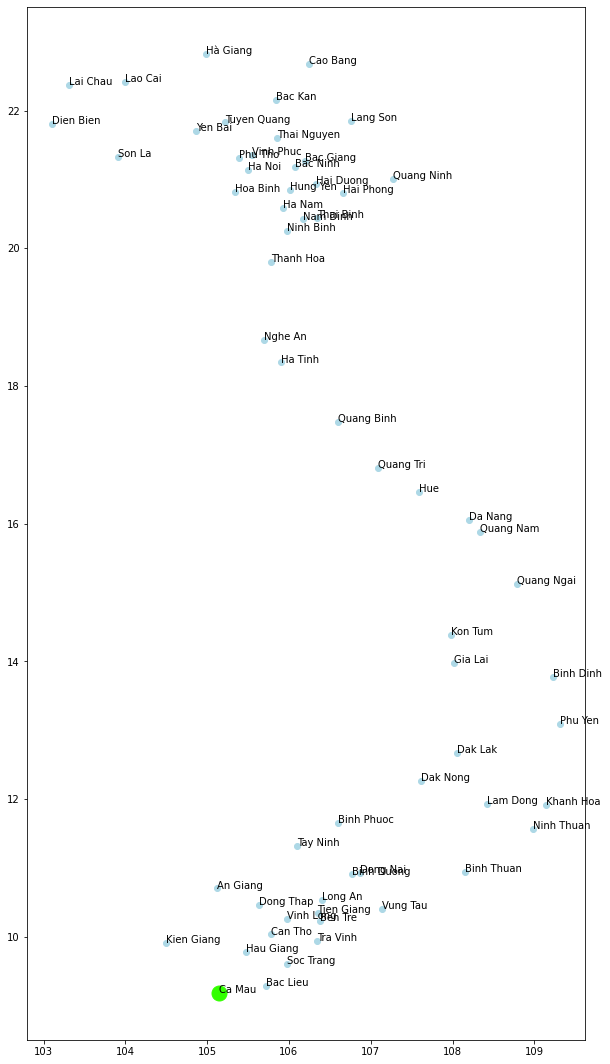

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FuncAnimation, PillowWriter 

%matplotlib inline

fig = plt.figure()
fig,axes = plt.subplots(figsize = (10,19))
for j in range (1,len(latitude)):
    axes.scatter(longtitude[j], latitude[j], c = 'lightblue')
    axes.text(longtitude[j], latitude[j],province[j])
line, = axes.plot([],[],color = '#33FF00',marker='.',markersize=30)
def animate(i):
    x = long_check[i]
    y = lat_check[i]
    print(x,y)
    line.set_data(x,y)
    return line,

anim = FuncAnimation(fig, animate, frames = len(long_check), interval = 300, blit = True)

anim.save('path.gif', writer = 'pillow')